## 3. Regression model

### 1. Problem and Overview
The gallstone status prediction is a classisification problem. This particular dataset present a few challenges: 
- small sample size
- potential gender imbalance
- excessive and correlated features

Our goal is to build and evaluate models that are robust, generalizable, and interpretable. In this notebook we will use LogisticRegression with elasticnet solver that combines L1 (LASSO) and L2 (Ridge) regularization. To stabilize models we apply cross validation (CV) and nested CV. We also demonstrate a feature selection strategy based on the outcome of LASSO fitting and effects of data stratification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score



path_train_data = "data/train_data_fold_split.csv"
path_test_data = "data/test_data.csv"
path_train_data_strat = "data/train_data_fold_split_strat.csv"
path_test_data_strat = "data/test_data_strat.csv"

### 2. Splitting Strategy

To ensure reproducibility and avoid data leakage:

- 30% held out as test set for final evaluation.

- 70% training set used for model development.

Two stratification strategies are tested:

Gallstone only (standard clinical outcome stratification).

Gallstone + Gender (to account for gender imbalance in gallstone prevalence).

We load the data and read in splits for 5-fold cross-validation. We drop features that are highly skewed (hyperlipidemia, hypothyroidism, cad) since they have just a few positive samples and would rather create noise. Diabetes has 43 positive cases that is also not too many, so this feature should be treated carefully.

In [2]:
train_data = pd.read_csv(path_train_data)
test_data  = pd.read_csv(path_test_data)

folds = train_data[[c for c in train_data.columns if c.startswith("Fold")]]
fold_names = folds.columns.to_list()
strat_columns = ["strat"]
exclude_features = ["hyperlipidemia", "hypothyroidism", "cad"]

X_train = train_data.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train = train_data["gallstone"]
X_test = test_data.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test = test_data["gallstone"]

splits = []

for fold in fold_names:
    train_idx =  folds.index[folds[fold] == "train"].to_numpy()
    val_idx = folds.index[folds[fold] == "val"].to_numpy()
    splits.append((train_idx.tolist(), val_idx.tolist()))

### 3. Model evaluation concept

For evaluation we will check scores on each fold separately, the whole train set and the test set. For fold score the model is trained on the fold train data and tested on the fold validation set. After that the model is retrained on the whole train data and the scores on the train data (for consistency) and the test data are evaluated. The scores are saved in json-like style that makes it easy to save pipeline results (optionally) or to combine them to a dataframe.

Following metrics are chosen for pipeline evaluation: accuracy, roc auc, recall and precision.

In [3]:
from scripts.pipeline_utils import get_pipeline_results, show_pipeline_summary, show_pipeline_folds, show_pipeline_coef, plot_learning_curve

c:\Users\Anna Lyamkina\.conda\envs\tfenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4. Model selection
#### 4.1. Baseline Model

We start with a simple Logistic Regression with elasticnet and l1_ratio = 0.5. This baseline provides a reference performance. From now on we use the train/test split stratified on the gallstone status that provides balanced datasets.

In [4]:
# baseline 
pipelines_results = []

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 1,
        l1_ratio=0.5
    ))
])


pipelines_results.append(get_pipeline_results(
    pipeline_1, name="baseline", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names
    ))
show_pipeline_summary(pipelines_results)


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline,0.758,0.055,0.855,0.811,0.829,0.054,0.932,0.847,0.706,0.072,0.827,0.702,0.788,0.061,0.875,0.892


The baseline model performs well on the test set, but mean CV performance on folds is lower, so the test results could be over optimistic. 

#### 4.2. GridCV Model

We now ehnance the regularization by tuning hyperparameters (C and l1_ration) on 5-fold CV splits that are already prepared in the train data file. Roc_auc was chosen for scoring accuracy in folds as it is robust and standard in biomedical modelling. GridCV provides a more stable model compared with the baseline.

In [5]:
# cv on predefined splits

scoring_gridcv = "roc_auc"

pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000,
        random_state=42))
])

param_grid = {
    "logreg__C": [0.001, 0.01, 0.1, 1],
    "logreg__l1_ratio": [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
}

grid_2 = GridSearchCV(
    estimator=pipeline_2,
    param_grid=param_grid,
    cv=splits,
    scoring=scoring_gridcv,
    verbose=0
)

grid_2.fit(X_train, y_train)

pipeline_2_best = grid_2.best_estimator_
print("Grid 2 Best parameters:", grid_2.best_params_)

pipelines_results.append(get_pipeline_results(
    pipeline_2_best, name="gridcv",  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names
    ))
show_pipeline_summary(pipelines_results)

Grid 2 Best parameters: {'logreg__C': 1, 'logreg__l1_ratio': 0.9}


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline,0.758,0.055,0.855,0.811,0.829,0.054,0.932,0.847,0.706,0.072,0.827,0.702,0.788,0.061,0.875,0.892
gridcv,0.758,0.060,0.850,0.800,0.833,0.050,0.933,0.845,0.697,0.074,0.818,0.681,0.796,0.074,0.874,0.889


The variance of Roc_auc in cv folds (the metric that was optimized by GridCV) decreases slightly. It shows that the model becomes more stable.

#### 4.3. Nested CV

Next we add nested CV to the model. The nested CV provides an unbiased estimate of generalization error as it tunes hyperparameters in an inner loop (3-fold CV here) and uses outer loop with 5-fold CV to evaluate errors. This gives a more conservative but realistic generalization estimate. Here we will use nested CV also to build a model for deployment by selecting a parameter set with the best score on outer folds.

The inner CV should use the same stratification that the outer CV, hence the gallstone status.

In [6]:
# nested cv

nested_cv_fold_scores = []
nested_cv_fold_best_params = []

for i, (train_idx, val_idx) in enumerate(splits):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    strat_fold = y_train.iloc[train_idx]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold, strat_fold)

    pipeline_3_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga",
        random_state=42))
])
    grid_3 = GridSearchCV(
        estimator=pipeline_3_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_3.fit(X_train_fold, y_train_fold)   # inner CV tuning
    score = grid_3.score(X_val_fold, y_val_fold)   # outer validation
    best_params = grid_3.best_params_
    nested_cv_fold_scores.append(score)
    nested_cv_fold_best_params.append(best_params)

nested_cv_best_params = nested_cv_fold_best_params[np.argmax(nested_cv_fold_scores)]
pipeline_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_best_params['logreg__C'],
        l1_ratio=nested_cv_best_params['logreg__l1_ratio']
    ))
])
# print(nested_cv_best_params)
pipelines_results.append(get_pipeline_results(
    pipeline_3, name="nested cv",  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names
    ))
show_pipeline_summary(pipelines_results)


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline,0.758,0.055,0.855,0.811,0.829,0.054,0.932,0.847,0.706,0.072,0.827,0.702,0.788,0.061,0.875,0.892
gridcv,0.758,0.060,0.850,0.800,0.833,0.050,0.933,0.845,0.697,0.074,0.818,0.681,0.796,0.074,0.874,0.889
nested cv,0.759,0.055,0.850,0.811,0.833,0.050,0.934,0.844,0.694,0.073,0.818,0.702,0.800,0.068,0.874,0.892


CV Roc_auc std drops further confirming the model stabilization.

### 5 Feature Selection

Test results differ from the mean CV accuracy strongly. Our dataset has 38 features that risk overfitting and limit clinical usability. There are several strategies to reduce feature dimensionality that include e.g. principal component analysis (PCA) or f1-score. Here, we use LASSO penalization to select features: during the fit LASSO pushes coefficients of irrelevant or noisy features to zero. 

#### 5.1. LASSO model

To select features we build a simple model with l1_ratio = 1 and force a stronger regularization (C = 0.25), then we inspect the features with non-zero weights. 

In [7]:
# Lasso strong
pipeline_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])

pipeline_4.fit(X_train, y_train)
pipelines_results.append(get_pipeline_results(
    pipeline_4, name="Lasso",  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names
    ))

# optionally show weights
# print("Pipeline 4 coefs:")
# for (k, v) in zip(X_train.columns, pipeline_4.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features = [X_train.columns[i] for (i, v) in enumerate(pipeline_4.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features ({len(lasso_features)}): {lasso_features}")

Lasso features (14): ['gender', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'bm', 'obesity', 'vfa', 'hfa', 'hdl', 'ast', 'crp', 'hgb', 'vitamin_d']


#### 5.2. Nested CV with selected features

We now retrain nested CV using selected features only.

In [8]:
# nested cv lasso features

X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]

nested_cv_lasso_fold_scores = []
nested_cv_lasso_fold_best_params = []

for i, (train_idx, val_idx) in enumerate(splits):
    X_train_fold, X_val_fold = X_train_lasso.iloc[train_idx], X_train_lasso.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    strat_fold = y_train.iloc[train_idx]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold, strat_fold)

    pipeline_5_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga",
        random_state=42))
])
    grid_5 = GridSearchCV(
        estimator=pipeline_3_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_5.fit(X_train_fold, y_train_fold)   # inner CV tuning
    score = grid_5.score(X_val_fold, y_val_fold)   # outer validation
    best_params = grid_5.best_params_
    nested_cv_lasso_fold_scores.append(score)
    nested_cv_lasso_fold_best_params.append(best_params)

nested_cv_lasso_best_params = nested_cv_lasso_fold_best_params[np.argmax(nested_cv_lasso_fold_scores)]
pipeline_5 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_lasso_best_params['logreg__C'],
        l1_ratio=nested_cv_best_params['logreg__l1_ratio']
    ))
])

pipelines_results.append(get_pipeline_results(
    pipeline_5, name="nested cv lasso features", X_train=X_train_lasso, y_train=y_train, X_test=X_test_lasso, y_test=y_test, splits=splits, fold_names=fold_names))

show_pipeline_summary(pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline,0.758,0.055,0.855,0.811,0.829,0.054,0.932,0.847,0.706,0.072,0.827,0.702,0.788,0.061,0.875,0.892
gridcv,0.758,0.060,0.850,0.800,0.833,0.050,0.933,0.845,0.697,0.074,0.818,0.681,0.796,0.074,0.874,0.889
nested cv,0.759,0.055,0.850,0.811,0.833,0.050,0.934,0.844,0.694,0.073,0.818,0.702,0.800,0.068,0.874,0.892
Lasso,0.764,0.057,0.823,0.726,0.825,0.057,0.895,0.827,0.718,0.075,0.809,0.638,0.793,0.073,0.832,0.769
nested cv lasso features,0.800,0.045,0.836,0.779,0.876,0.043,0.925,0.843,0.764,0.058,0.809,0.660,0.826,0.057,0.856,0.861


Reducing number of features made the model even more stable.

### 6. Stratification 

Now we repeat the workflow established above for stratified data for comparison.

In [9]:
train_data_strat = pd.read_csv(path_train_data_strat)
test_data_strat  = pd.read_csv(path_test_data_strat)

folds_strat = train_data_strat[[c for c in train_data_strat.columns if c.startswith("Fold")]]
#fold_names = folds_strat.columns.to_list()

X_train_strat = train_data_strat.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train_strat = train_data_strat["gallstone"]
X_test_strat = test_data_strat.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test_strat = test_data_strat["gallstone"]

splits_strat = []

for fold in fold_names:
    train_idx =  folds_strat.index[folds[fold] == "train"].to_numpy()
    val_idx = folds_strat.index[folds[fold] == "val"].to_numpy()
    splits_strat.append((train_idx.tolist(), val_idx.tolist()))

In [10]:
# baseline strat

pipeline_6 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 1,
        l1_ratio = 0.5
    ))
])

pipelines_results.append(get_pipeline_results(
    pipeline_6, name="baseline stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat, fold_names=fold_names
    ))

In [11]:
# cv on stratified splits
pipeline_7 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, random_state=42))
])

grid_7 = GridSearchCV(
    estimator=pipeline_7,
    param_grid=param_grid,
    cv=splits_strat,
    scoring=scoring_gridcv,
    verbose=0
)

grid_7.fit(X_train_strat, y_train_strat)

pipeline_7_best = grid_7.best_estimator_

pipelines_results.append(get_pipeline_results(
    pipeline_7_best, name="gridcv stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat, fold_names=fold_names
    ))

In [12]:
# nested cv stratified
nested_cv_fold_scores_strat = []
nested_cv_fold_best_params_strat = []

for i, (train_idx, val_idx) in enumerate(splits_strat):
    X_train_fold_strat, X_val_fold_strat = X_train_strat.iloc[train_idx], X_train_strat.iloc[val_idx]
    y_train_fold_strat, y_val_strat = y_train_strat.iloc[train_idx], y_train_strat.iloc[val_idx]
    strat_fold_strat = train_data_strat.iloc[train_idx]["strat"]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold_strat, strat_fold_strat)

    pipeline_8_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga", random_state=42))
])
    grid_8 = GridSearchCV(
        estimator=pipeline_8_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_8.fit(X_train_fold_strat, y_train_fold_strat)   # inner CV tuning happens here
    score = grid_8.score(X_val_fold_strat, y_val_strat)   # outer validation
    best_params = grid_8.best_params_
    nested_cv_fold_scores_strat.append(score)
    #print(f"{fold_names[i]} Grid 3 Best parameters: {best_params} best score: {score}")
    nested_cv_fold_best_params_strat.append(best_params)

nested_cv_best_params_strat = nested_cv_fold_best_params_strat[np.argmax(nested_cv_fold_scores_strat)]

pipeline_8 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        random_state=42,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_best_params_strat['logreg__C'],
        l1_ratio=nested_cv_best_params_strat['logreg__l1_ratio']
    ))
])

pipelines_results.append(get_pipeline_results(
    pipeline_8, name="nested cv stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat, fold_names=fold_names
    ))

In [13]:
# Lasso strong stratified
pipeline_9 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])


pipeline_9.fit(X_train_strat, y_train_strat)
pipelines_results.append(get_pipeline_results(
    pipeline_9, name="Lasso stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat, fold_names=fold_names
    ))

# print("Pipeline 9 coefs:")
# for (k, v) in zip(X_train_strat.columns, pipeline_9.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features_strat = [X_train_strat.columns[i] for (i, v) in enumerate(pipeline_9.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features for stratified data ({len(lasso_features_strat)}): {lasso_features_strat}")

Lasso features for stratified data (17): ['comorbidity', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'protein', 'bm', 'obesity', 'vfa', 'hfa', 'glucose', 'hdl', 'ast', 'alp', 'crp', 'hgb', 'vitamin_d']


In [14]:
# nested cv lasso features stratified

X_train_lasso_strat = X_train_strat[lasso_features_strat]
X_test_lasso_strat = X_test_strat[lasso_features_strat]

nested_cv_lasso_fold_scores_strat = []
nested_cv_lasso_fold_best_params_strat = []

for i, (train_idx, val_idx) in enumerate(splits_strat):
    X_train_fold_strat, X_val_fold_strat = X_train_lasso_strat.iloc[train_idx], X_train_lasso_strat.iloc[val_idx]
    y_train_fold_strat, y_val_strat = y_train_strat.iloc[train_idx], y_train_strat.iloc[val_idx]
    strat_fold_strat = train_data_strat.iloc[train_idx]["strat"]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold_strat, strat_fold_strat)

    pipeline_10_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga", random_state=42))
])
    grid_10 = GridSearchCV(
        estimator=pipeline_10_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_10.fit(X_train_fold_strat, y_train_fold_strat)   # inner CV tuning happens here
    score = grid_10.score(X_val_fold_strat, y_val_strat)   # outer validation
    best_params = grid_10.best_params_
    nested_cv_lasso_fold_scores_strat.append(score)
    #print(f"{fold_names[i]} Grid 5 Best parameters: {best_params} best score: {score}")
    nested_cv_lasso_fold_best_params_strat.append(best_params)

nested_cv_lasso_best_params_strat = nested_cv_lasso_fold_best_params_strat[np.argmax(nested_cv_lasso_fold_scores_strat)]
pipeline_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        random_state=42,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_lasso_best_params_strat['logreg__C'],
        l1_ratio=nested_cv_best_params_strat['logreg__l1_ratio']
    ))
])
pipelines_results.append(get_pipeline_results(
    pipeline_10, name="nested cv lasso features stratified", X_train=X_train_lasso_strat, y_train=y_train_strat, 
                X_test=X_test_lasso_strat, y_test=y_test_strat, splits=splits_strat, fold_names=fold_names
                                              ))

### 7. Results

Now we come to the evaluation of pipelines and discuss how regularization, feature selection and stratification affect the performance

#### 7.1. Model performance

Below is the summary of train/test and fold-averaged performance for selected metrics for 10 pipelines we designed combined by stratification strategy.

In [15]:
show_pipeline_summary(pipelines_results[:5], title="Pipeline summary, stratification on gallstone status")
show_pipeline_summary(pipelines_results[5:], title="Pipeline summary, stratification on gallstone status + gender")

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline,0.758,0.055,0.855,0.811,0.829,0.054,0.932,0.847,0.706,0.072,0.827,0.702,0.788,0.061,0.875,0.892
gridcv,0.758,0.060,0.850,0.800,0.833,0.050,0.933,0.845,0.697,0.074,0.818,0.681,0.796,0.074,0.874,0.889
nested cv,0.759,0.055,0.850,0.811,0.833,0.050,0.934,0.844,0.694,0.073,0.818,0.702,0.800,0.068,0.874,0.892
Lasso,0.764,0.057,0.823,0.726,0.825,0.057,0.895,0.827,0.718,0.075,0.809,0.638,0.793,0.073,0.832,0.769
nested cv lasso features,0.800,0.045,0.836,0.779,0.876,0.043,0.925,0.843,0.764,0.058,0.809,0.660,0.826,0.057,0.856,0.861


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline stratified,0.771,0.069,0.845,0.663,0.844,0.052,0.926,0.769,0.740,0.124,0.826,0.646,0.787,0.078,0.857,0.674
gridcv stratified,0.770,0.059,0.845,0.663,0.845,0.050,0.926,0.768,0.740,0.110,0.826,0.667,0.785,0.071,0.857,0.667
nested cv stratified,0.771,0.057,0.850,0.663,0.844,0.052,0.928,0.763,0.743,0.107,0.826,0.667,0.785,0.070,0.865,0.667
Lasso stratified,0.756,0.051,0.800,0.737,0.823,0.049,0.895,0.809,0.717,0.086,0.752,0.750,0.780,0.077,0.828,0.735
nested cv lasso features stratified,0.785,0.061,0.827,0.705,0.865,0.048,0.910,0.785,0.753,0.089,0.789,0.708,0.807,0.083,0.851,0.708


Main observations:

- Baseline vs GridCV: grid search stabilized the modeal and did not improve performance much, the baseline model was already not bad. The effect should be more pronounced for a larger sample size.

- Nested CV: CV accuracies are further stabilized.

- LASSO feature selection: dropped redundant features, stabilized performance across folds.

- Nested CV with LASSO: even more stable model, CV mean performance is closer to train and test performanc-> better generalization.

**Stratification**:

Gallstone-only stratification → better model scores, but potential gender imbalance in folds.

Gallstone+Gender stratification → fairer folds, lower scores (trade-off: balance vs performance).

#### 7.2. Model Stability

We can also visualize model performance over folds to evaluate stability.

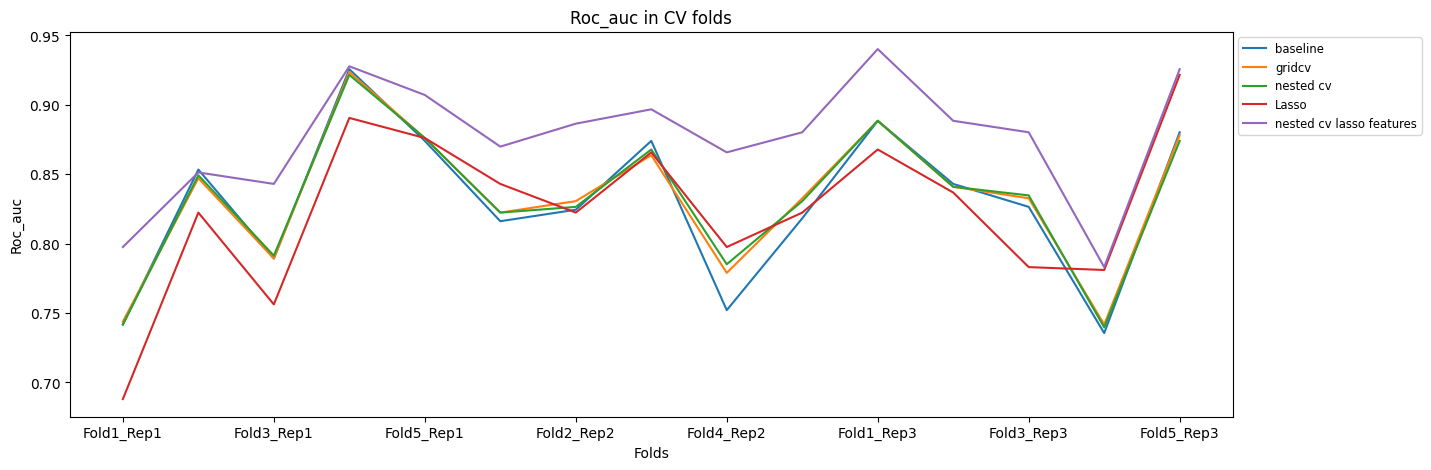

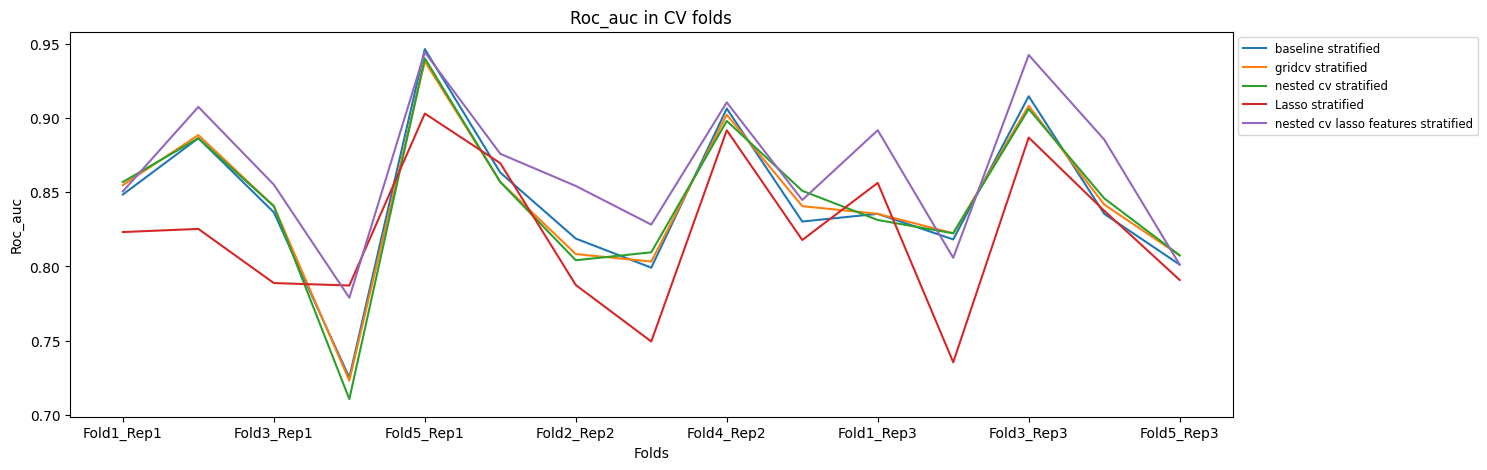

In [16]:
# we plot results for folds stratified by gallstone only and gallsone + gender separately as they use different folds
show_pipeline_folds(pipelines_results[:5], show_tables=False, metrics=["roc_auc"])
show_pipeline_folds(pipelines_results[5:], show_tables=False, metrics=["roc_auc"])

The fold performance changes in a large range suggesting that the folds are significantly different in "difficulty" for a model. In addition, it indicates possible class imbalance in folds (also for stratified data).

#### 7.3. Learning Curve

We can gain more insight about our modelling with learning curves that show how training and validation are changed with the dataset size. Below are learning curves for nested CV models with preselected features.

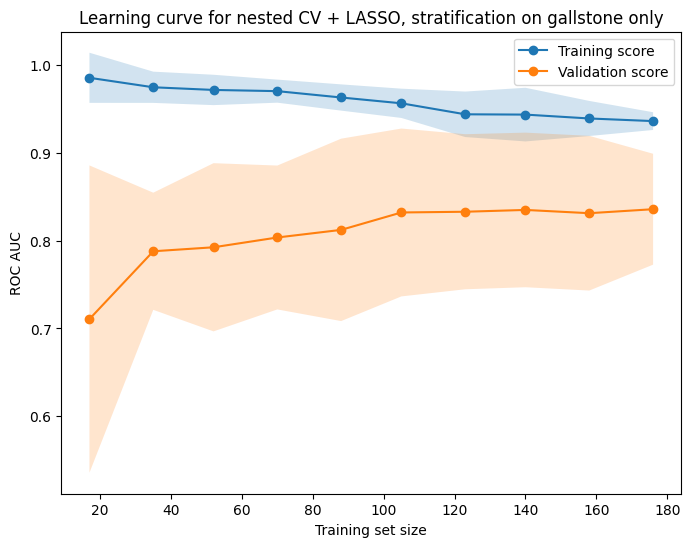

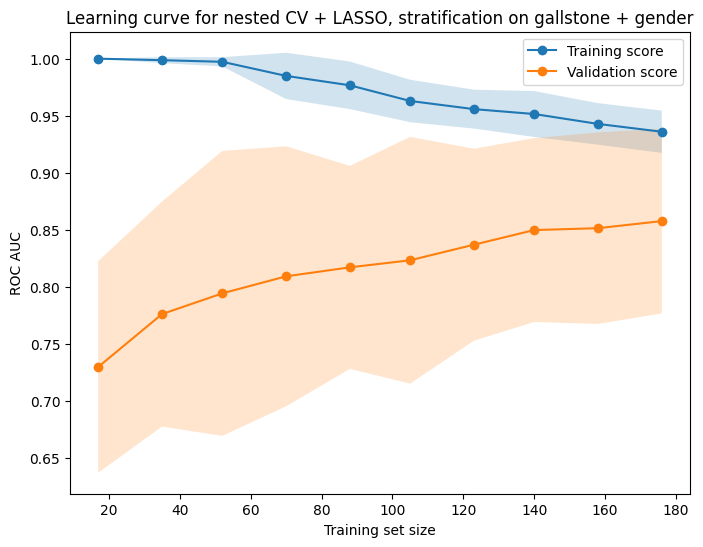

In [17]:
plot_learning_curve(pipeline=pipeline_5, X_train=X_train, y_train=y_train, stratification=train_data["gallstone"], 
                    title = "Learning curve for nested CV + LASSO, stratification on gallstone only")

plot_learning_curve(pipeline=pipeline_10, X_train=X_train_strat, y_train=y_train_strat, stratification= train_data_strat["strat"],
                    title = "Learning curve for nested CV + LASSO, stratification on gallstone + gender")

Both plots demonstrate a gap between training and validation curves. Interestingly, for stratification on gallstone status only the validation curve hits a plateau that means that more data would not improve the results. The training accuracy is significantly higher than validation indicating that the model is **overfitting** because there are too many parameters relative to signal. The model is **variance-limited** and stronger resularization and/or feature selection is required.

For stratification on gallstone status + gender the validation curve does not reach plateau which means this **model could benefit from more data**. This is beacuse the stratified splitting creates harder (but more representative) folds and the model is now **data-limited** ratherthan overfitting.

#### 7.4. Model coefficients

Finally, we check how importance of features changed when we tuned models.

In [18]:
show_pipeline_coef(pipelines_results)

name,baseline,gridcv,nested cv,Lasso,nested cv lasso features,baseline stratified,gridcv stratified,nested cv stratified,Lasso stratified,nested cv lasso features stratified
age,0.075,0.001,0.000,0.000,0.000,0.157,0.242,0.316,0.000,0.000
gender,-1.051,-1.064,-1.072,-0.033,-1.116,-0.472,-0.536,-0.602,0.000,0.000
comorbidity,-0.111,-0.083,-0.076,0.000,0.000,-0.389,-0.403,-0.416,-0.061,-0.361
diabetes,0.354,0.313,0.305,0.174,0.258,0.727,0.749,0.770,0.333,0.742
height,-0.045,0.000,0.000,0.000,0.000,0.000,-0.004,-0.112,0.000,0.000
weight,0.000,0.000,0.000,0.000,0.000,0.191,0.194,0.253,0.000,0.000
bmi,0.450,0.508,0.514,0.000,0.000,0.453,0.438,0.361,0.000,0.000
tbw,0.068,0.021,0.010,0.000,0.000,0.000,0.000,0.104,0.000,0.000
ecw,0.000,0.000,0.000,0.000,0.000,0.000,-0.040,-0.221,0.000,0.000
icw,0.873,0.882,0.891,0.389,1.117,0.949,0.907,0.919,0.570,1.531


There is a big difference in feature weights for different data stratification strategies. When gender is not considered in splitting, it becomes one of the most importance features, while for a more balanced splitting it is excluded by LASSO completely. Features like e.g. bone mass and total body weight ratio become less important in dataset stratified by gender since they are intrinsically connected with gender. In the same time e.g. comorbidity and diabetes become more important features. Since diabetes has only 43 positive cases as stated above, it could be added to stratification (makes splitting much more complex though), or potentially excluded frommodelling.

### 8. Final Takeaways

Nested CV is essential: it guards against optimistic bias and provides more reliable performance estimates.

Stratification matters: balancing folds by gallstone + gender did not reduce CV scores in this dataset, but it ensures fairer evaluation across subgroups.

Regularization and feature selection: elastic net and LASSO help reduce noise and improve interpretability without major loss in accuracy.

**Key point: the project demonstrates end-to-end workflow (splitting, CV, nested CV, feature selection), with emphasis on methodology rather than raw metrics.**